# **Sales Analysis using MCMC Methods**
The Sales Analysis dataset is collected from Kaggle to determine which products we should continue to sell. It contains historical sales data (identified with the column titled File_Type) along with current active inventory that is in need of evaluation (i.e., File Type = "Active"). The historical data shows sales for the past 6 months. The binary target (1 = sale, 0 = no sale in past six months) is likely the primary target that should drive the analysis.

Further, to implement MCMC we need to explore different distributions, below is a compact explanation which could help me to choose a reference distribution.
distribution:

- **Uniform Distribution:** The uniform distribution defines equal probability over a given range for a continuous distribution. For this reason, it is important as a reference distribution(prior decision).

- **Normal Distribution:** also known as the Gaussian distribution, it is symmetric, unimodal, and asymptotic, and the mean, median, and mode are all equal. A normal distribution is perfectly symmetrical around its center. That is, the right side of the center is a mirror image of the left side.

- **Half-normal Distribution:** It is a Normal distribution truncated to only have nonzero probability density for values greater than or equal to the location of the peak.

- **Skew-normal Distribution:** If one tail is longer than another, the distribution is skewed. It can be either left or right skewed and the mean will be shifted to either side of the median.

- **Dirichlet Distribution:** The Dirichlet distribution is the conjugate prior distribution of the categorical distribution (a generic discrete probability distribution with a given number of possible outcomes) and multinomial distribution (the distribution over observed counts of each possible category in a set of categorically distributed observations). This means that if a data point has either a categorical or multinomial distribution.

- **Beta Distribution:** Applied to model the behavior of random variables limited to intervals of finite length in a wide variety of disciplines. It is the conjugate prior probability distribution for the Bernoulli, binomial, negative binomial and geometric distributions. Also, it is a suitable model for the random behavior of percentages and proportions.

- **Categorical Distribution:** It is a discrete probability distribution that describes the possible results of a random variable that can take on one of K possible categories, with the probability of each category separately specified.

- **GLM Distribution:** Some common GLM families are Gaussian, Binomial, Poisson, Gamma and Inverse-Gamma. The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.

- **Binomial Distribution:** The binomial is a type of distribution that has two possible outcomes for e.g., success or failure. It summarizes the likelihood that a value will take one of two independent values under a given set of parameters or assumptions. Also, there is only one outcome for each trial, with same probability of success, and independent of one another.

- **Negative Binomial Distribution:** has very similar characteristics to the Poisson distribution except that it has two parameters (𝜇 and 𝛼) which enables it to vary its variance independently of its mean.

- **Poisson Distribution:** is generally used to describe the probability of a given number of events occurring on a fixed time/space interval.

Below is the explanantion of MCMC Sampling methods that are commonly used using **PyMC** library:

- **NUTS:** NUTS uses a recursive algorithm to build a set of likely candidate points that spans a wide swath of the target distribution, stopping automatically when it starts to double back and retrace its steps.

- **Metropolis Hastings:** An algorithm is a MCMC method for obtaining a sequence of random samples by random walk from a probability distribution from which direct sampling is difficult.

- **Hamiltonian MonteCarlo:** obtains a sequence of random samples which converge to being distributed according to a target probability distribution. It reduces the correlation between successive sampled states by proposing moves to distant states which maintain a high probability of acceptance due to the approximate energy conserving properties.

- **CategoricalGibbsMetropolis:** The Gibbs Sampling is a Monte Carlo Markov Chain method that iteratively draws an instance from the distribution of each variable, conditional on the current values of the other variables in order to estimate complex joint distributions. It always accept the proposal. A Metropolis-within-Gibbs step method optimized for categorical variables. Step method supports two types of proposals: A uniform proposal and a proportional proposal.

Now let's get started...

## **Import Libraries**

In [ ]:
# importing libraries
import numpy as np
import scipy
from scipy import stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
import os
import csv
import arviz as az
import seaborn as sns
sns_c = sns.color_palette(palette='deep')

import pandas as pd
from sklearn import preprocessing
import theano as T

import math 
import itertools
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import pymc3 as pm
import pymc3.distributions.continuous as pmc
import pymc3.distributions.discrete as pmd
import pymc3.math as pmm

from sklearn.model_selection import train_test_split


import json
# s = json.load(open('../style/bmh_matplotlibrc.json'))
# matplotlib.rcParams.update(s)
# matplotlib.rcParams['figure.figsize'] = (10, 3)
# matplotlib.rcParams['font.size'] = 14
# matplotlib.rcParams['ytick.major.size'] = 20

#bambi

!pip install bambi
from bambi import Family, Likelihood, Link
from scipy import special


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Fetch Data**

In [ ]:
filename = "https://raw.githubusercontent.com/Rumsha001/ML2/main/dataset/Sales_analysis_processed.csv"
# read data from csv file
data = pd.read_csv(filename)
df = pd.DataFrame(data)
df

,File_Type,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ItemCount,LowUserPrice,LowNetPrice,Class
0,0,0,0.00000,4.395988,1,0.611166,0.494965,0.193114,0.935044,0.679876,1
1,0,0,0.00000,2.051461,1,0.909498,0.272952,0.941431,0.000000,0.331824,1
2,0,0,0.00000,0.000000,0,0.304771,0.506077,0.820735,0.974421,0.597241,1
3,0,1,8.12105,1.172264,1,0.298994,1.100168,0.482785,4.322765,1.775493,1
4,0,1,8.12105,0.586132,1,1.152914,1.341654,0.675899,0.129105,0.512256,1
...,...,...,...,...,...,...,...,...,...,...,...
198912,1,0,0.00000,2.051461,1,0.188151,0.801692,1.303520,0.273057,1.293772,3
198913,1,0,0.00000,2.344527,1,0.407750,2.717414,1.569052,0.271121,1.598264,3
198914,1,0,0.00000,0.586132,1,0.151528,0.550084,0.555203,0.773986,0.696531,3
198915,1,0,0.00000,0.586132,1,0.337948,0.516529,0.555203,0.885016,0.809061,3


## **Helper Functions**

In [ ]:
# Loading dataset creditcard
def read_csv(filename):
  with open(filename, 'r') as f:
    reader=csv.reader(f, delimiter=',') 
    labels=next(reader)

    raw_data=[]
    for row in reader:
        raw_data.append(row)

  data = np.array(raw_data)
  data = data.astype(np.float)
  return data

def logistic(l):
  # x = np.random.randn(100)
  # x_shared = T.shared(x)
  # return x_shared*l
  return 1 / (1 + T.tensor.exp(-l))

# def logistic(x=x, beta=beta):
#     return 1.0 / (1. + np.exp(beta * x))

def view_distribution(data):
  az.plot_kde(data, rug=True)
  return plt.yticks([0], alpha=0)

def get_scaled_df(df,cols):
  rob_sc = preprocessing.RobustScaler()
# df2= df.copy(deep=True)
  scaled_t = rob_sc.fit_transform(df.reshape(-1,1))
  # scaled_amount = rob_sc.fit_transform(df[cols[1]].values.reshape(-1,1))
  # # Amount and Time are Scaled so we are removing unsacled features!
  # df.drop(cols, axis=1, inplace=True)
  # df.insert(cols[0],'Time',value=scaled_time)
  # df.insert(cols[1],'Amount',value=scaled_amount)
  return scaled_t

def run_ppc(model_, trace_, y_obs, thetas):
  with model_:
    
    forecast_1 = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(trace=trace_))
    posterior_samples = forecast_1.posterior_predictive['y_obs'].values.flatten()

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
  sns.countplot(x=thetas, color=sns_c[0], ax=ax[0])
  ax[0].set(title='Sample Distribution', xlabel='y', xlim=(-1, 10))
  sns.countplot(x=posterior_samples, color=sns_c[2], ax=ax[1])
  ax[1].set(title='Posterior Predictive Distribution', xlabel='y', xlim=(-1, 10));

  return forecast_1, posterior_samples

In [ ]:
def plots(trace):    
    # az.plot_trace(data=trace);
    az.summary(trace)
    
    #typical trace plots
    print("trace plot")
    pm.plot_trace(trace)
    
    #check if your posteriors look reasonable
    print("posterior plot")
    pm.plot_posterior(trace)
    
    # check if your variables have reasonable credible intervals, 
    #and Gelman–Rubin scores close to 1
    print("forest plot")
    pm.plot_forest(trace)
    
    #check if your chains are impaired by high autocorrelation. 
    #Also remember that thinning your chains is a waste of time at best, and deluding yourself at worst.
    print("autocorr plot")
    pm.plot_autocorr(trace)
    
    # ideally the energy and marginal energy distributions should look very similar. 
    # Long tails in the distribution of energy levels indicates deteriorated sampler efficiency.
    pm.energyplot(trace)

    # pm.plot_ppc(trace)

    #a souped-up version of pm.plot_posterior. 
    #It doesn’t seem to be wildly useful unless you’re plotting posteriors from multiple models.
    print("density plot")
    pm.plot_density(trace)
    
    # Display the total number and percentage of divergent chains
    # diverging = trace['diverging']
    # print('Number of Divergent Chains: {}'.format(diverging.nonzero()[0].size))
    # diverging_pct = diverging.nonzero()[0].size / len(trace) * 100
    # print('Percentage of Divergent Chains: {:.1f}'.format(diverging_pct))
    
    # az.plot_pair(trace, 
    #              var_names=['p','p'], 
    #              kind='kde', 
    #              group="posterior",
    #              divergences=True,
    #              colorbar=True,
    #              divergences_kwargs={'color': 'C2'})

In [ ]:

# columns to convert to date format
def change_type_to_date(df, to_date):
  # Deal with incorrect data in date column
  for i in to_date:
    df[i] = pd.to_datetime(df[i], errors='coerce')
  return df
    
 # columns to convert to numerical format
def change_type_to_numeric(df, to_numeric):
  # Deal with incorrect data in numeric columns
  for i in to_numeric:
    df[i] = pd.to_numeric(df[i], errors='coerce')
  return df
    
# columns to delete
def drop_useless_columns(df, cols_to_delete):
  # Drop useless columns before dealing with missing values
  for i in cols_to_delete:
    df.drop(i, axis=1, inplace=True)
  return df
    
#drop all rows which contain more than 40% missing values
def drop_useless_rows(df):
  min_threshold = math.ceil(len(df.columns)*0.4)
  df = df.dropna(thresh=min_threshold)
  return df
    
# drop rows in which columns specified by the driver program has missing values
def drop_na_rows(df):
  df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
  return df
    
# Deal with missing values according to map, e.g., {'age': df['age'].median(), 'city': 'Karachi'}
def fill_na_vals(df, fill_na_map):
  for col,val in fill_na_map.items():
    df[col].fillna(val, inplace=True)
  return df
    
# Deal with missing values according to the interpolation
def fill_na_interpolate(df, cols_to_interpolate):
  for i in cols_to_interpolate:
    df[i] = df[i].interpolate(method ='linear', limit_direction ='forward')
  return df


#basic analysis
def basicanalysis(df):
    print("Shape is:\n", df.shape)
    print("\n Columns are:\n", df.columns)
    print("\n Types are:\n", df.dtypes)
    print("\n Sum of missing values are:\n", df.isna().sum())
    # print("\n Statistical Analysis of Numerical Columns:\n", df.describe())

#string column analysis analysis
def stringcolanalysis(df):
    stringcols = df.select_dtypes(exclude=[np.number, "datetime64"])
    fig = plt.figure(figsize = (8,10))
    for i,col in enumerate(stringcols):
        fig.add_subplot(4,2,i+1)
        fig.savefig('Categorical.png')
        df[col].value_counts().plot(kind = 'bar', color='black' ,fontsize=10)
        plt.tight_layout()
        plt.title(col)

#numerical analysis
def numcolanalysis(df):
    numcols = df.select_dtypes(include=np.number)
    
    # Box plot for numerical columns
    # for col in numcols:
    #     fig = plt.figure(figsize = (5,5))
    #     sns.boxplot(df[col], color='grey', linewidth=1)
    #     plt.tight_layout()
    #     plt.title(col)
    #     plt.savefig("Numerical.png")
    
    # Lets also plot histograms for these numerical columns
    df.hist(column=list(numcols.columns),bins=5, grid=False, figsize=(20,15),
                 color='#86bf91', zorder=2, rwidth=0.9)

# Perform correlation analysis over numerical columns
def correlation_anlysis(df):
    # NOTE: If label column is non-numeric, 'encode' it before calling this function 
    numcols = df.select_dtypes(include=np.number)
    corr = numcols.corr()
    ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    )
    
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')


# Apply label encoding on specified columns
def apply_label_encoding(df, cols=[]):
    le = preprocessing.LabelEncoder()
    for i in cols:
        le.fit(df[i])
        df[i] = le.transform(df[i])
    return df


# One-Hot/dummy encoding on specified columns
def onehotencoding(df):
    df = pd.get_dummies(df)
    return df

# One Hot encoding with Pandas categorical dtype
def onehotencoding_v2(df, cols=[]):
    for col in cols:
        df[col] = pd.Categorical(df[col])
        dfDummies = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, dfDummies], axis=1)
        df = df.drop(col, axis=1)
    return df


## **EDA**
* As the data I have used here is already preprocessed on other notebook. Here, I will just plot some distribution of the important columns.
* Here along with EDA, I have also performed the Kolmogorov-Smirnov test for goodness of fit of the distributon especially for the prior selection. 
This performs a test of the distribution F(x) of an observed
random variable against a given distribution G(x).

In [ ]:
#  Data Summary
basicanalysis(df)
df.describe()

Shape is:
 (198917, 11)

 Columns are:
 Index(['File_Type', 'SoldFlag', 'SoldCount', 'ReleaseNumber',
       'New_Release_Flag', 'StrengthFactor', 'PriceReg', 'ItemCount',
       'LowUserPrice', 'LowNetPrice', 'Class'],
      dtype='object')

 Types are:
 File_Type             int64
SoldFlag              int64
SoldCount           float64
ReleaseNumber       float64
New_Release_Flag      int64
StrengthFactor      float64
PriceReg            float64
ItemCount           float64
LowUserPrice        float64
LowNetPrice         float64
Class                 int64
dtype: object

 Sum of missing values are:
 File_Type           0
SoldFlag            0
SoldCount           0
ReleaseNumber       0
New_Release_Flag    0
StrengthFactor      0
PriceReg            0
ItemCount           0
LowUserPrice        0
LowNetPrice         0
Class               0
dtype: int64


,File_Type,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ItemCount,LowUserPrice,LowNetPrice,Class
count,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000
mean,0.617951,0.065334,1.000000,1.000000,0.642248,1.000000,1.000000,1.000000,1.000000,1.000000,1.402746
std,0.485890,0.247115,6.002276,1.132478,0.479340,1.362519,0.954245,0.906217,2.229200,2.744130,0.687269
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.293066,0.000000,0.144496,0.462070,0.506925,0.158477,0.383284,1.000000
50%,1.000000,0.000000,0.000000,0.586132,1.000000,0.521185,0.769567,0.772456,0.519003,0.725571,1.000000
75%,1.000000,0.000000,0.000000,1.465329,1.000000,1.280157,1.276194,1.206963,1.298798,1.184872,2.000000
max,1.000000,1.000000,592.836654,29.013522,1.000000,15.561917,139.407515,61.362010,456.393646,408.668608,3.000000


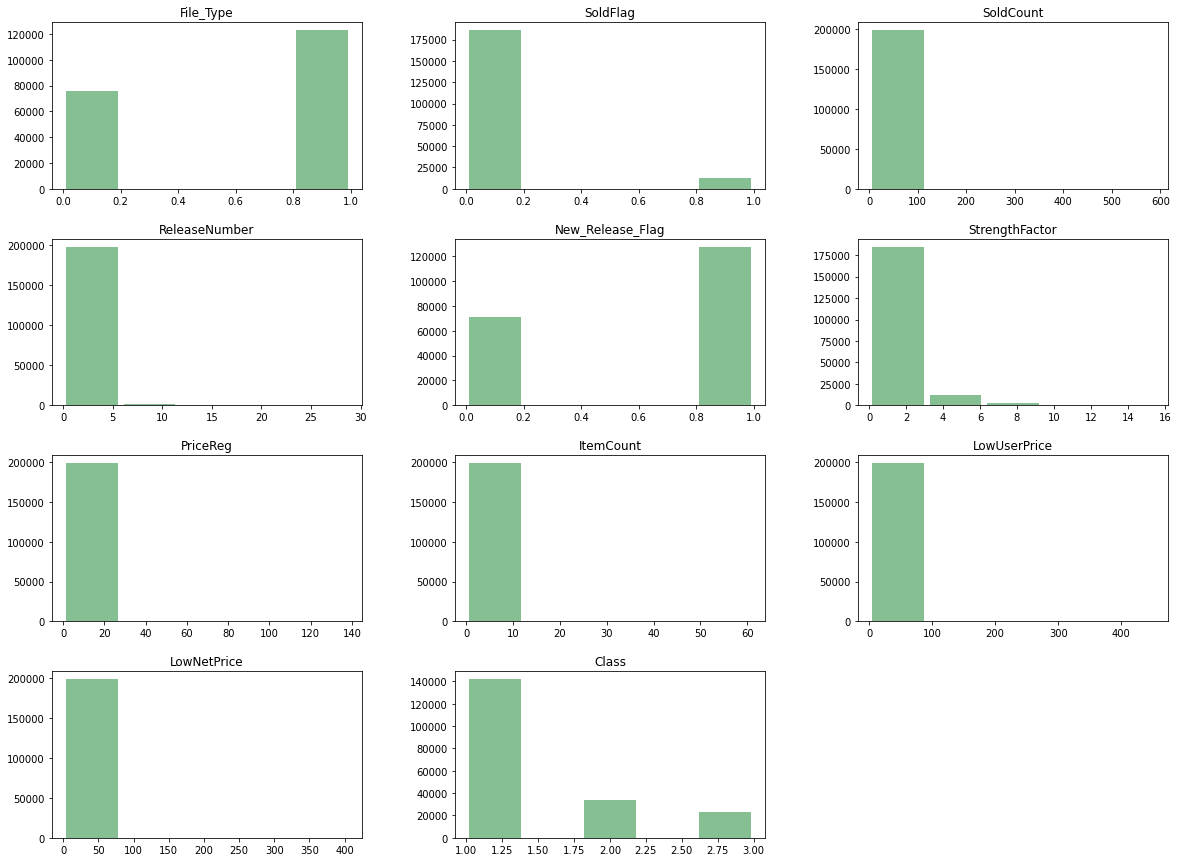

In [ ]:
numcolanalysis(df)

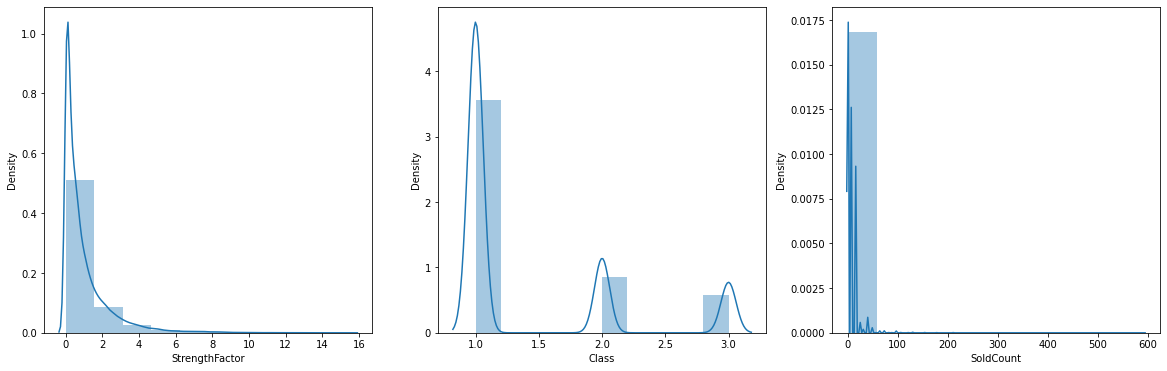

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(20,6))
s = sns.distplot(ax = ax1,  a=df['StrengthFactor'],bins=10)
s = sns.distplot(ax = ax2, a=df['Class'],bins=10)
s = sns.distplot(ax = ax3, a=df['SoldCount'],bins=10)

In [ ]:
list_of_dists = ['alpha','beta','cauchy','chi','cosine','dgamma','dweibull','expon','exponnorm','foldcauchy','foldnorm',
                 'gamma','halfcauchy','halfnorm', 'invgamma','invgauss', 'invweibull','laplace','logistic',
                 'lognorm','norm', 'uniform','wald','weibull_min','weibull_max']

In [ ]:
def show_goodness(list,col):
  results = []
  for i in list:
    dist = getattr(stats, i)
    param = dist.fit(col)
    a = stats.kstest(col, i, args=param)
    results.append((i,a[0],a[1]))
    
  results.sort(key=lambda x:float(x[2]), reverse=True)
  for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

In [ ]:
print("\n-----For Sold Count------")
show_goodness(list_of_dists, df['SoldCount'])
print("\n-----For File Type------")
show_goodness(list_of_dists, df['File_Type'])
print("\n-----For Class------")
show_goodness(list_of_dists, df['Class'])


-----For Sold Count------
alpha: statistic=0.7292309228349722, pvalue=0.0
beta: statistic=0.9346472322078886, pvalue=0.0
cauchy: statistic=0.6932066870484677, pvalue=0.0
chi: statistic=0.9346662175630895, pvalue=0.0
cosine: statistic=0.6165141918662825, pvalue=0.0
dgamma: statistic=0.5, pvalue=0.0
dweibull: statistic=0.49999999999869005, pvalue=0.0
expon: statistic=0.9346662175681314, pvalue=0.0
exponnorm: statistic=0.9335570271224224, pvalue=0.0
foldcauchy: statistic=0.47156867341724773, pvalue=0.0
foldnorm: statistic=0.9315527612057154, pvalue=0.0
gamma: statistic=0.5600173666549513, pvalue=0.0
halfcauchy: statistic=0.8771828982045895, pvalue=0.0
halfnorm: statistic=0.9346662162240703, pvalue=0.0
invgamma: statistic=0.8143265566904222, pvalue=0.0
invgauss: statistic=0.7352750423088106, pvalue=0.0
invweibull: statistic=0.9346660643810002, pvalue=0.0
laplace: statistic=0.5000000003424159, pvalue=0.0
logistic: statistic=0.4696056910814595, pvalue=0.0
lognorm: statistic=0.93357336654770

- ### From above plot, we can see that plot no 0 and 29 have different behaviour because these 2 columns are time and amount and they are only columns which are not normalised. 
- ### Also, from Machine learning implementation on this same dataset, we have figured out some important features which are as follows: 
- ### TIME(0), V6, V5, V7, V10, V11, V12, V14, V17, V20, AMOUNT(29), CLASS(30)

- ### In the next, step we will first normalised aforesaid columns and reduce the size of predictors.

## **Sampling**
Below given code is important to run as it contains variables that are used in all sampling methods

In [ ]:
# converting it into simple arrays
y_simple = df['SoldFlag']
x_df = df[['SoldCount','File_Type','Class']]
# x_df = (x_df - x_df.mean()) / x_df.std()
x_df = x_df.values
x_df

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 3.],
       [0., 1., 3.],
       [0., 1., 3.]])

### **NUTS Sampling**
* Since we have no prior knowledge about these parameters, we can assume that it could be anything.
* First, I have used Normal distribution and Deterministic Distribution over the predictors values. Here, we are applying logistic regrassion and using Bernoulli since we have two classes.
* Secondly, the data is also standardized instead of just mean-centered here.
* Lastly, due to resources contraints, I chose only 100 draws with NUTS.
 

**Convergence Diagnosis**
* There are 79 divergences because of less number of tuning steps.
* The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
* Since, we have a large dataset and for that number of draws should be atleast greater than 100 in order to cover more data and make plausible estimations  as this process has hardly covered 10% of the entire data however, within time and resources, I could not exceed my draws.
* To diagnose convergence, I have used trace and forest plot after which my session got expired.
* From trace plot, we can witness the divergences in all plots which are on the right side. Also, we can say that the caterpillar is not fuzzy.
* Similarly from left plots, it is evident that the chains are hardly overlapping on each other.
* From forest plot wih 94% HDI, we can see few variables are centered while few of them are spread across the mean.

In [ ]:
with pm.Model() as nuts_model:
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=3) 
    μ = α + pm.math.dot(x_df, β) 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_df[:,0])
    yl = pm.Bernoulli('yl', p=θ, observed=y_simple) 
    trace_0 = pm.sample(100)  

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 892 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
az.summary(trace_0, var_names=["α","β"])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-14.473,3.814,-22.396,-8.477,0.512,0.364,51.0,34.0,1.05
β[0],3.773,0.672,2.569,4.948,0.191,0.138,12.0,32.0,1.14
β[1],-0.479,2.060,-5.262,2.500,0.265,0.189,73.0,120.0,1.01
β[2],-1.225,1.837,-4.283,1.969,0.288,0.205,47.0,66.0,1.06


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


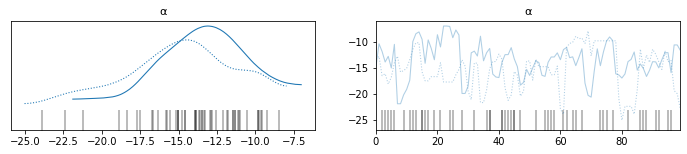

In [ ]:
az.plot_trace(trace_0, var_names=["α"]);

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


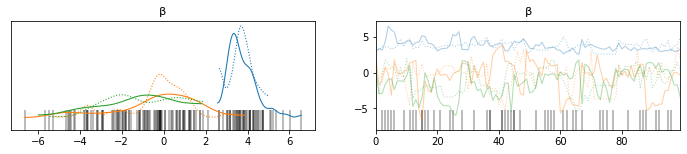

In [ ]:
az.plot_trace(trace_0, var_names=["β"]);

In [ ]:
# pm.save_trace(trace=trace_0, directory=r"c:\Users\t1");

Text(0, 0.5, "['File_Type']")

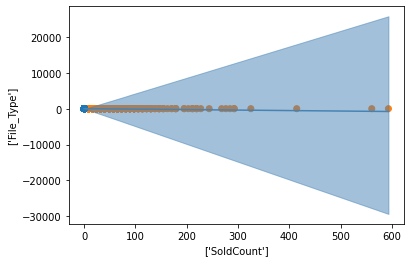

In [ ]:
idx = np.argsort(x_df[:,0]) 
bd = trace_0['bd'].mean(0)[idx] 
plt.scatter(x_df[:,0], x_df[:,1], c=[f'C{x}' for x in y_simple]) 
plt.plot(x_df[:,0][idx], bd, color='steelblue'); 
az.plot_hdi(x_df[:,0], trace_0['bd'], color='steelblue')
plt.xlabel(['SoldCount']) 
plt.ylabel(['File_Type'])

Got error No model on context stack. trying to find log_likelihood in translation.


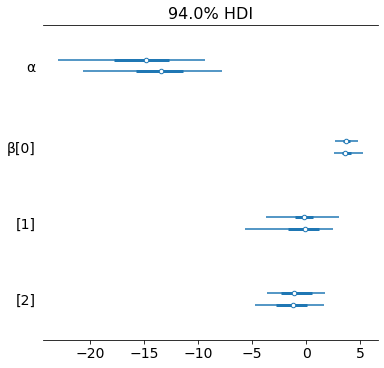

In [ ]:
az.plot_forest(trace_0, var_names=["α","β"]);

### **NUTS Sampling using GLM**
Here, I have used Generalized Linear Model from Bambi library, there are 3 components to any GLM: 
- Random Component – refers to the probability distribution of the response variable (Y); e.g. normal distribution for Y in the linear regression, or binomial distribution for Y in the binary logistic regression. 
- Systematic Component - specifies the explanatory variables  in the model, more specifically their linear combination in creating the so called linear predictor.
- Link Function,  or  - specifies the link between random and systematic components. It says how the expected value of the response relates to the linear predictor of explanatory variables.
- I have used Bernoulli as a likelihood and logit as its link and then connected it to the GLM family; Bernoulli again.

**Convergence Diagnosis**

* There were total 756 divergences after tuning. 
* The model ran on auto-selected 1000 draws and 1000 tuning steps.
* The acceptance probability does not match the target. Tuning steps should be increased.
* The number of effective samples is smaller than 25% for some parameters.
* The r_hat score is ~1 which is good.
* To diagnose convergence, I have used trace plot. The chains are overlapping eachother and plots are extremely fuzzy which means that the sampling predictions moving in a certain range. 
* However, some variable are more inclined towards negative values as the mean is shifted to negative. Also, we witnessed some error value in mcse_mean	and mcse_sd. 
* All in all, I would say that an increased number of draws could have given better results.

In [ ]:
from bambi import Model

# Construct likelihood distribution ------------------------------
# This must use a valid PyMC3 distribution name.
# 'parent' is the name of the variable that represents the mean of the distribution.
# The mean of the Bernoulli family is given by 'p'.
likelihood = Likelihood("Bernoulli", parent="p")

# Set link function ----------------------------------------------
# There are two alternative approaches.
# 1. Pass a name that is known by Bambi
link = Link("logit")

# 2. Build everything from scratch
# link: A function that maps the response to the linear predictor
# linkinv: A function that maps the linear predictor to the response
# linkinv_backend: A function that maps the linear predictor to the response
#                  that works with Theano tensors
link = Link(
    "my_logit",
    link=special.expit,
    linkinv=special.logit,
    linkinv_backend=T.tensor.nnet.sigmoid
)

# Construct the family -------------------------------------------
# Families are defined by a name, a Likelihood and a Link.
family = Family("bernoulli", likelihood, link)

# Now it's business as usual
model = Model('SoldFlag ~ Class + File_Type + SoldCount', df, family=family)
glm_traces = model.fit()

Modeling the probability that SoldFlag==1
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, SoldCount, File_Type, Class]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1501 seconds.
There were 229 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7146319974872645, but should be close to 0.8. Try to increase the number of tuning steps.
There were 527 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
az.summary(glm_traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-9.784,2.534,-15.132,-5.486,0.118,0.084,465.0,501.0,1.00
Class,-1.033,2.357,-5.356,3.634,0.117,0.083,405.0,410.0,1.01
File_Type,-4.247,2.927,-9.888,0.194,0.179,0.138,331.0,379.0,1.01
SoldCount,2.404,0.149,2.134,2.672,0.009,0.006,263.0,192.0,1.00


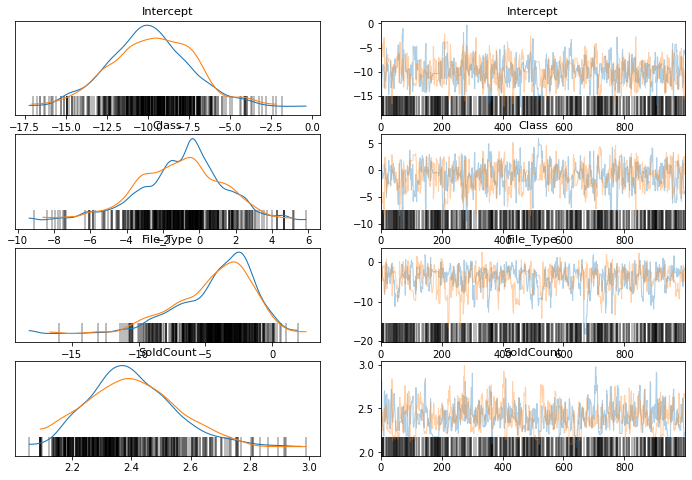

In [ ]:
az.plot_trace(glm_traces, compact=False);

### **Metropolis Hasting Sampling**
* Since we have 3 labels in Class feature which is a predictor, I have used Gaussian mixture model to capture the peaks in the form of clusters.
* Then I have used Uniform distribution for priors of other two predictors along with Deterministic distribution which takes one fixed value.
* Then, I have used Bernoulli as a likelihood.

**Convergence Diagnosis**
* The rhat statistic is larger than 1.4 for some parameters. 
* The sampler did not converge.
* The estimated number of effective samples is smaller than 200 for some parameters.
* Due to limited resources, I chose only 300 draws with two steps: Elemwise for Categorical Sampling and NUTS for remaining variables.
* From trace plot, we can see that FileType and SoldCount have atleast somehow overlapping chains and there r_hat score is also ~1. 
* But Class feature unlikely has given worse results, for which I would say that the choice for its prior and catergory selection was incorrect. It also has covered very small portion of the sample. As we can see on class_p plot, it tried to capture categorical values but due to lesser number of samples it failed.

In [ ]:
with pm.Model() as mh_model:
    class_p = pm.Dirichlet("class_p", a=np.array([10, 40, 20]), shape=3)
    # ensure all clusters have some points
    p_min_potential = pm.Potential("p_min_potential", T.tensor.switch(T.tensor.min(class_p) < 0.1, -np.inf, 0))
    centers = pm.Normal("centers", mu=[1.2, 2, 2.8], sigma=0.5, shape=3)
    # measurement error
    class_sd = pm.Uniform("class_sd", lower=0, upper=10)
    # latent cluster of each observation
    category = pm.Categorical("category", p=class_p)
    # likelihood for each observed value
    s_class = pm.Normal("s_class", mu=centers[category], sigma=class_sd, observed=y_simple)
  

    #priors on parameters
    alpha = pm.Uniform('beta_0', lower=10, upper= 100)
    # beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    file_type = pm.HalfNormal('file_type', sigma=1)
    sold_count = pm.Exponential('sold_count', lam=0.5)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(alpha +  file_type* df['File_Type'] +
                               sold_count*df['SoldCount']))
    # p = alpha + beta[0]*x_perc_change_min + beta[1]*x_monthly_minutes
    obs=pm.Bernoulli("obs", p, observed=y_simple)
    
    #Sampling ------ Metropolis
    step1 = pm.Metropolis(vars=[alpha, file_type, sold_count, p, class_sd, centers, class_p])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category]) 
    sample_mh = pm.sample(draws=300, step=[step1, step2])

Only 300 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [class_p]
>>Metropolis: [centers]
>>Metropolis: [class_sd]
>>Metropolis: [beta_0]
>>Metropolis: [file_type]
>>Metropolis: [sold_count]
>CategoricalGibbsMetropolis: [category]


Sampling 2 chains for 1_000 tune and 300 draw iterations (2_000 + 600 draws total) took 503 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
az.summary(sample_mh, var_names=['file_type', 'sold_count',  'class_sd', 'class_p'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
file_type,0.000,0.000,0.000,0.000,0.000,0.000,91.0,106.0,1.01
sold_count,1.901,1.891,0.047,5.591,0.157,0.111,127.0,173.0,1.01
class_sd,0.247,0.000,0.247,0.248,0.000,0.000,10.0,32.0,1.96
class_p[0],0.148,0.038,0.103,0.221,0.008,0.006,33.0,43.0,1.36
class_p[1],0.570,0.057,0.466,0.665,0.009,0.007,39.0,67.0,1.12
class_p[2],0.282,0.052,0.187,0.387,0.008,0.006,45.0,69.0,1.36


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


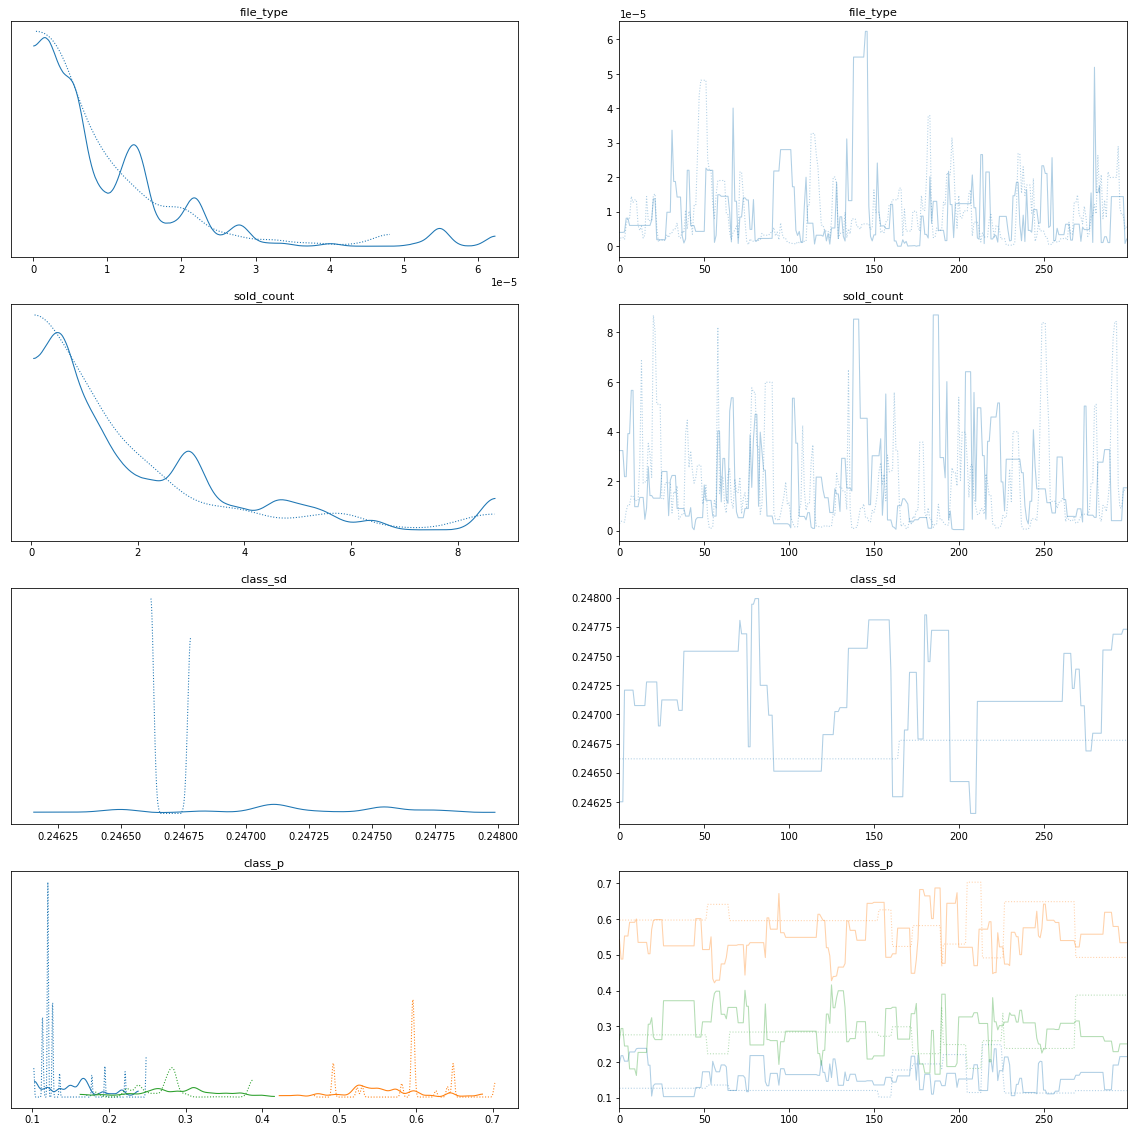

In [ ]:
az.plot_trace(sample_mh,  var_names=['file_type', 'sold_count', 'class_sd', 'class_p'],figsize=(20,20));

Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f33d7f72a10>,
      dtype=object)

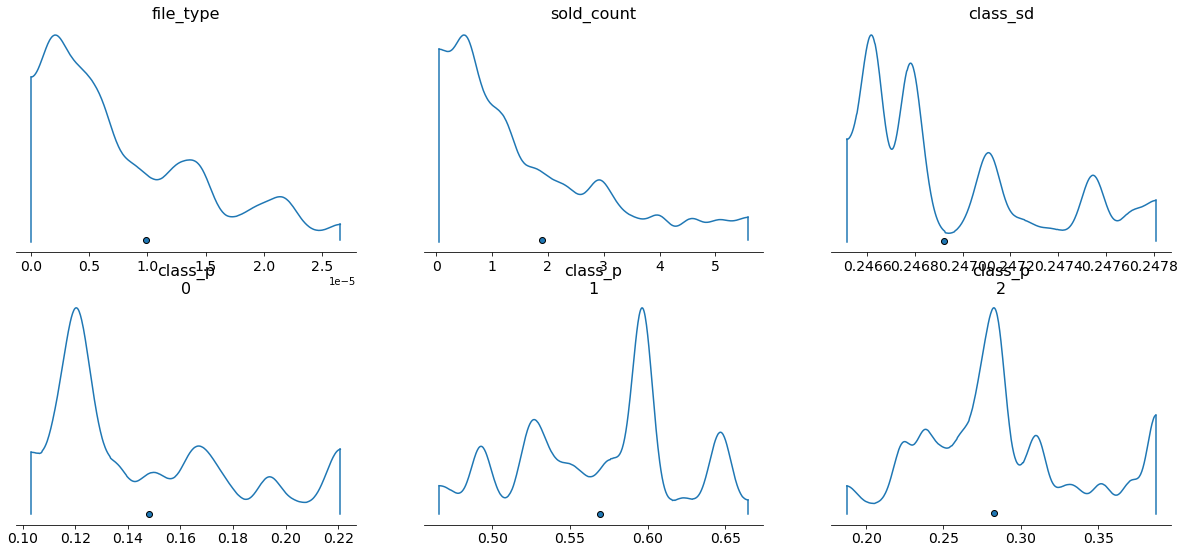

In [ ]:
az.plot_density(sample_mh, var_names=['file_type', 'sold_count',  'class_sd', 'class_p'])

### **Sampling Class Feature Separately with NUTS**
####**Convergence Diagnosis**
- Since the class has poorly sampled in all the above sampling methods and distributions. Here I have separately implemented it wih NUTS and set priors for unknown parameters.
- While it was working fast, I draw 1000 samples which has given good results with gelman rubin *r_hat* 1.01 and 0 divergence.
- The traceplot has also shown that the chain were overlapping except at tails.
- Fuzzy caterpillar plot is a good sign for maintaining it around the mean.
- Lastly, Density plot has also shown the mean closer to 0.

Overall, I can say that the increment in drawing samples has a great impact on results.


In [ ]:
with pm.Model() as class_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = pm.Normal('beta', mu=0, sd=5)
    sigma = pm.HalfNormal('sigma', sd=4)

    # Expected value of outcome
    mu = alpha + beta*df['Class']
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=y_simple)

    start = pm.find_MAP()

    # instantiate sampler - not really a good practice
    step = pm.NUTS(scaling=start)

    # draw 1000 posterior samples
    trace_class = pm.sample(1000, step, start=start)

Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 128 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
az.summary(trace_class)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.144,0.001,0.141,0.146,0.0,0.0,469.0,463.0,1.01
beta,-0.056,0.001,-0.057,-0.054,0.0,0.0,469.0,527.0,1.01
sigma,0.244,0.000,0.243,0.245,0.0,0.0,2260.0,1291.0,1.00


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f691d9f9250>,
      dtype=object)

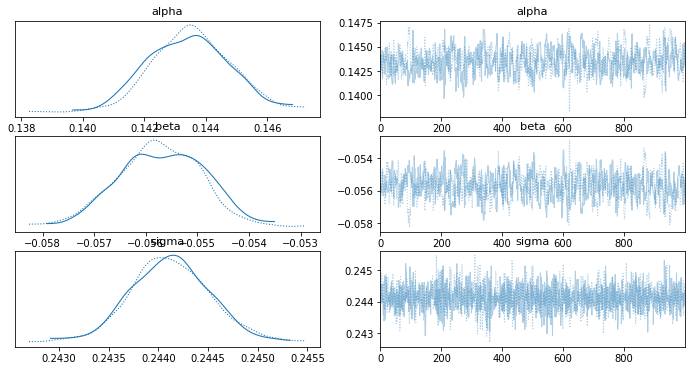

In [ ]:
az.plot_trace(trace_class)

Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6925dd0b90>,
      dtype=object)

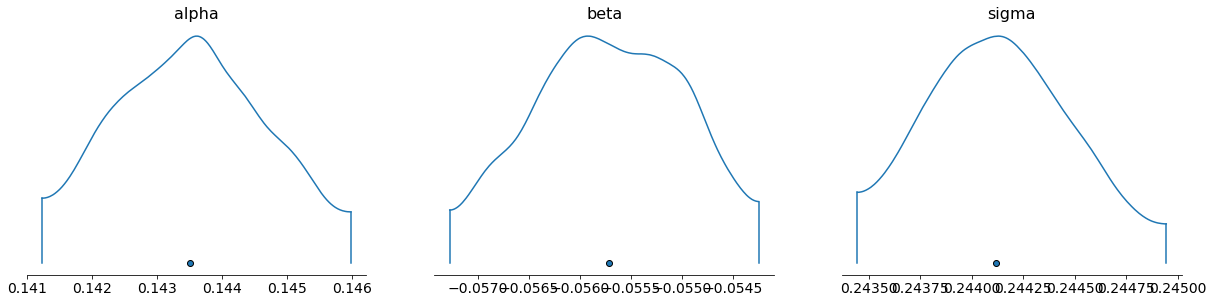

In [ ]:
az.plot_density(trace_class)